In [2]:
# Libraries
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import time

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Dropout

First we load the dataset and split it into input and output data. Then, we can split it into training, validation and testing using train_test_split

In [3]:
# Load dataset and sample it
data = pd.read_csv('baseline_dataset.csv')

# Split data into input and output
X = data['url']
y = data['label']

# Tokenize on character level
print("Tokenizing...")
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(X)

# Convert into sequences
sequences = tokenizer.texts_to_sequences(X)

# Pad sequences to a uniform length of 200
print("Padding...")
padded = pad_sequences(sequences, maxlen=200)

# Split dataset into 70% training, 20% validation and 10% testing
X_train, X_test, y_train, y_test = train_test_split(padded, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=1/3, random_state=42)

# Check data shapes
print("Train:", X_train.shape, y_train.shape)
print("Valid:", X_val.shape, y_val.shape)
print("Test:", X_test.shape, y_test.shape)

Tokenizing...
Padding...
Train: (327838, 200) (327838,)
Valid: (93668, 200) (93668,)
Test: (46834, 200) (46834,)


Now we will build our model

In [4]:
# Create model
model = Sequential()

# Input layer
model.add(Input(shape=(200,)))

# Embedding layer
# This gets us the num of entries in the vocabulary that the tokenizer created, we add +1 because the index starts from 0
vocab = len(tokenizer.word_index) + 1 
embedding_layer = Embedding(input_dim=vocab, output_dim=16)
model.add(embedding_layer)

# Convolution layers
model.add(Conv1D(128, 3, activation='relu'))
model.add(MaxPooling1D())
model.add(Conv1D(128, 3, activation='relu'))
model.add(MaxPooling1D())
model.add(Dropout(0.2))

# Fully connected layers
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile model
print("Compiling...")
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'precision', 'recall'])

# Show summary
model.summary()

Compiling...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 200, 16)        │         1,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 198, 128)       │         6,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 99, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 97, 128)        │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 48, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 48, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6144)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       393,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 450,017 (1.72 MB)

 Trainable params: 450,017 (1.72 MB)

 Non-trainable params: 0 (0.00 B)

The output above shows a summary of our model. Next we will train it and evaluate to see how it performs

In [5]:
# Train the model
history = model.fit(X_train, y_train, epochs=8, batch_size=128, validation_data=(X_val, y_val))

# Evaluate
loss, accuracy, precision, recall = model.evaluate(X_test, y_test)

# Print results
print("Loss:", round(loss, 4))
print("Accuracy:", round(accuracy, 4))
print("Precision:", round(precision, 4))
print("Recall:", round(recall, 4))

Epoch 1/8
2562/2562 ━━━━━━━━━━━━━━━━━━━━ 57s 21ms/step - accuracy: 0.8870 - loss: 0.2443 - precision: 0.8851 - recall: 0.8540 - val_accuracy: 0.9542 - val_loss: 0.1146 - val_precision: 0.9517 - val_recall: 0.9449
Epoch 2/8
2562/2562 ━━━━━━━━━━━━━━━━━━━━ 53s 21ms/step - accuracy: 0.9542 - loss: 0.1130 - precision: 0.9458 - recall: 0.9520 - val_accuracy: 0.9629 - val_loss: 0.0937 - val_precision: 0.9686 - val_recall: 0.9472
Epoch 3/8
2562/2562 ━━━━━━━━━━━━━━━━━━━━ 54s 21ms/step - accuracy: 0.9651 - loss: 0.0874 - precision: 0.9607 - recall: 0.9613 - val_accuracy: 0.9686 - val_loss: 0.0795 - val_precision: 0.9612 - val_recall: 0.9686
Epoch 4/8
2562/2562 ━━━━━━━━━━━━━━━━━━━━ 54s 21ms/step - accuracy: 0.9698 - loss: 0.0763 - precision: 0.9658 - recall: 0.9664 - val_accuracy: 0.9679 - val_loss: 0.0811 - val_precision: 0.9524 - val_recall: 0.9766
Epoch 5/8
2562/2562 ━━━━━━━━━━━━━━━━━━━━ 54s 21ms/step - accuracy: 0.9734 - loss: 0.0664 - precision: 0.9709 - recall: 0.9694 - val_accuracy: 0.9693

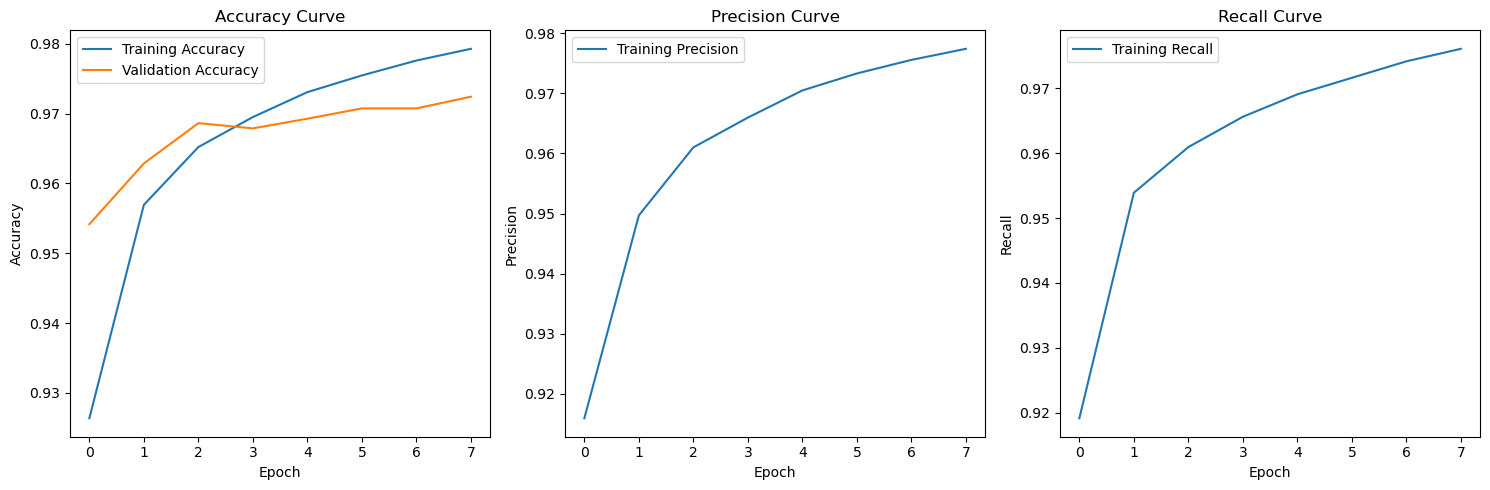

In [6]:
# Extract metrics
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_precision = history.history['precision']
val_precision = history.history['val_precision']
train_recall = history.history['recall']
val_recall = history.history['val_recall']

# Create figure
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Accuracy
axs[0].plot(train_accuracy, label='Training Accuracy')
axs[0].plot(val_accuracy, label='Validation Accuracy')
axs[0].set_title('Accuracy Curve')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend()

# Precision
axs[1].plot(train_precision, label='Training Precision')
axs[1].set_title('Precision Curve')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Precision')
axs[1].legend()

# Recall
axs[2].plot(train_recall, label='Training Recall')
axs[2].set_title('Recall Curve')
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('Recall')
axs[2].legend()

plt.tight_layout()
plt.show()